In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader
import math
import copy
from torch.autograd import Variable
from numpy import linalg as LA
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class _get_layers(nn.Module):
    def __init__(self, elements=7):
        super().__init__()
        self.elements = elements
    def forward(self, x):
        sem = x[:, :3, :, :]
        c = x[:, 3, :, :]
        c = c[:, None, :, :] 
        ca = x[:, 4, :, :]
        ca = ca[:, None, :, :]
        mg = x[:, 5, :, :]
        mg = mg[:, None, :, :]
        na = x[:, 6, :, :]
        na = na[:, None, :, :]
        o = x[:, 7, :, :]
        o = o[:, None, :, :]
        s = x[:, 8, :, :]
        s = s[:, None, :, :]
        cl = x[:, 9, :, :]
        cl = cl[:, None, :, :]
        return sem, c, ca, mg, na, o, s, cl

In [3]:
def attention(q, k, v, d_k, mask=None, dropout=None):
    
    scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)
    scores = F.softmax(scores, dim=-1)
    
    if dropout is not None:
        scores = dropout(scores)
        
    output = torch.matmul(scores, v)
    return output

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, heads, d_model, dropout = 0.1):
        super().__init__()
        
        self.d_model = d_model
        self.d_k = d_model // heads
        self.h = heads
        
        self.q_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        
        bs = q.size(0)
        # a = self.q_linear(q)
        # print(a.shape)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        
        # print(q.shape)
        # transpose to get dimensions bs * h * sl * d_model
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        # calculate attention using function we will define next
        scores = attention(q, k, v, self.d_k, mask, self.dropout)
        
        # concatenate heads and put through final linear layer
        concat = scores.transpose(1,2).contiguous().view(bs, -1, self.d_model)
        
        output = self.out(concat)
    
        return output

In [5]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout = 0.1):
        super().__init__() 
        # We set d_ff as a default to 2048
        self.linear_1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model)
    def forward(self, x):
        x = self.dropout(F.relu(self.linear_1(x)))
        x = self.linear_2(x)
        return x
    
# net = FeedForward(158)
# x=torch.randn(10, 158)
# y = net(x)
# print(y.shape)

In [6]:
class Norm(nn.Module):
    def __init__(self, d_model, eps = 1e-6):
        super().__init__()
    
        self.size = d_model
        # create two learnable parameters to calibrate normalisation
        self.alpha = nn.Parameter(torch.ones(self.size))
        self.bias = nn.Parameter(torch.zeros(self.size))
        self.eps = eps
    def forward(self, x):
        norm = self.alpha * (x - x.mean(dim=-1, keepdim=True)) \
        / (x.std(dim=-1, keepdim=True) + self.eps) + self.bias
        return norm
    
# net = Norm(158)
# x=torch.randn(10, 158)
# y = net(x
# print(y.shape)

In [7]:
# build an encoder layer with one multi-head attention layer and one # feed-forward layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout = 0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.attn = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn(x2,x2,x2,mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x
    
# build a decoder layer with two multi-head attention layers and
# one feed-forward layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.norm_2 = Norm(d_model)
        self.norm_3 = Norm(d_model)
        
        self.dropout_1 = nn.Dropout(dropout)
        self.dropout_2 = nn.Dropout(dropout)
        self.dropout_3 = nn.Dropout(dropout)
        
        self.attn_1 = MultiHeadAttention(heads, d_model)
        self.attn_2 = MultiHeadAttention(heads, d_model)
        self.ff = FeedForward(d_model)
    def forward(self, x, e_outputs, src_mask=None, trg_mask=None):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.attn_2(x2, e_outputs, e_outputs, src_mask))
        x2 = self.norm_3(x)
        x = x + self.dropout_3(self.ff(x2))
        return x

    # We can then build a convenient cloning function that can generate multiple layers:
def get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [8]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 300):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

# net = PositionalEncoder(282)
# x = src = torch.randn(8, 211, 282)
# y = net(x)
# y.shape

# net = PositionalEncoder(158)
# x = src = torch.randn(8, 118, 158)
# y = net(x)
# print(y.shape)

In [9]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(EncoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, src, mask=None):
        # x = self.embed(src)
        x = src
        # x = self.pe(x)
        for i in range(self.N):
            x = self.layers[i](x, mask)
        return self.norm(x)
    
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads):
        super().__init__()
        self.N = N
        # self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model)
        self.layers = get_clones(DecoderLayer(d_model, heads), N)
        self.norm = Norm(d_model)
    def forward(self, trg, e_outputs, src_mask=None, trg_mask=None):
        # x = self.embed(trg)
        # x = self.pe(x)
        x = trg
        for i in range(self.N):
            x = self.layers[i](x, e_outputs, src_mask, trg_mask)
        return self.norm(x)

In [10]:
class Transformer(nn.Module):
    def __init__(self, src_vocab, trg_vocab, d_model, N, heads):
        super().__init__()
        self.encoder = Encoder(src_vocab, d_model, N, heads)
        self.decoder = Decoder(trg_vocab, d_model, N, heads)
        self.reduce = nn.Linear(d_model, trg_vocab)
        # self.reduce = nn.Linear(d_model, 1)
        self.linear_1 = nn.Linear(trg_vocab*src_vocab, trg_vocab)
        self.out = nn.Linear(56, 1)
    def forward(self, src, trg, src_mask=None, trg_mask=None):
        e_outputs = self.encoder(src, src_mask)
        d_output = self.decoder(trg, e_outputs, src_mask, trg_mask)
        output = self.reduce(d_output)
        output = output.view(output.shape[0], -1)        
        output = self.linear_1(output)
        output = output.view(-1)
        output = self.out(output)
        return output

In [11]:
src_vocab = 118
trg_vocab = 7
# t = Transformer(src_vocab, trg_vocab, 158, 3, 2)
# src = torch.randn(8, 118, 158)
# trg = torch.randn(8, 118, 158)
# # t = t.to('cuda')
# # src = src.to('cuda')
# # trg = trg.to('cuda')
# output = t(src, trg)
# print(output.shape)

In [12]:
class _feature_extraction(nn.Module):
    def __init__(self):
        super(_feature_extraction, self).__init__()
        self.pool = nn.MaxPool2d(4, 4)
        self.conv1_sem = nn.Conv2d(3, 4, 5)
        self.conv2_sem = nn.Conv2d(4, 8, 5)
        self.conv1_c = nn.Conv2d(1, 4, 5)
        self.conv2_c = nn.Conv2d(4, 8, 5)
        self.conv1_ca = nn.Conv2d(1, 4, 5)
        self.conv2_ca = nn.Conv2d(4, 8, 5)
        self.conv1_mg = nn.Conv2d(1, 4, 5)
        self.conv2_mg = nn.Conv2d(4, 8, 5)
        self.conv1_na = nn.Conv2d(1, 4, 5)
        self.conv2_na = nn.Conv2d(4, 8, 5)
        self.conv1_o = nn.Conv2d(1, 4, 5)
        self.conv2_o = nn.Conv2d(4, 8, 5)
        self.conv1_s = nn.Conv2d(1, 4, 5)
        self.conv2_s = nn.Conv2d(4, 8, 5)
        self.conv1_cl = nn.Conv2d(1, 4, 5)
        self.conv2_cl = nn.Conv2d(4, 8, 5)
    def forward(self, sem, c, ca, mg, na, o, s, cl):
        sem = self.pool(F.relu(self.conv1_sem(sem)))
        sem = self.pool(F.relu(self.conv2_sem(sem))) #torch.Size([4, 8, 211, 282])
        c = self.pool(F.relu(self.conv1_c(c)))
        c = self.pool(F.relu(self.conv2_c(c))) #torch.Size([4, 8, 211, 282])
        ca = self.pool(F.relu(self.conv1_ca(ca)))
        ca = self.pool(F.relu(self.conv2_ca(ca))) #torch.Size([4, 8, 211, 282])
        mg = self.pool(F.relu(self.conv1_mg(mg)))
        mg = self.pool(F.relu(self.conv2_mg(mg))) #torch.Size([4, 8, 211, 282])
        na = self.pool(F.relu(self.conv1_na(na)))
        na = self.pool(F.relu(self.conv2_na(na))) #torch.Size([4, 8, 211, 282])
        o = self.pool(F.relu(self.conv1_o(o)))
        o = self.pool(F.relu(self.conv2_o(o))) #torch.Size([4, 8, 211, 282])
        s = self.pool(F.relu(self.conv1_s(s)))
        s = self.pool(F.relu(self.conv2_s(s))) #torch.Size([4, 8, 211, 282])
        cl = self.pool(F.relu(self.conv1_cl(cl)))
        cl = self.pool(F.relu(self.conv2_cl(cl))) #torch.Size([4, 8, 211, 282])
        
        return sem, c, ca, mg, na, o, s, cl

In [13]:
class _cross_transformer(nn.Module):
    def __init__(self, device):
        super(_cross_transformer, self).__init__()
        
        # self.transformer = Transformer(211, 7, 282, 3, 6)
        self.transformer = Transformer(118, 7, 158, 3, 2)

    def forward(self, sem, c, ca, mg, na, o, s, cl):
        c_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        ca_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        mg_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        na_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        o_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        s_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        cl_predict = torch.empty((1,7), dtype=torch.float32).to(device)
        
        for i in range(sem.shape[0]):
            
            sem_i = sem[i]
            c_i = c[i]
            ca_i = ca[i]
            mg_i = mg[i]
            na_i = na[i]
            o_i = o[i]
            s_i = s[i]
            cl_i = cl[i]
            
            c_sem = self.transformer(c_i, sem_i)
            c_ca = self.transformer(c_i, ca_i)
            c_mg = self.transformer(c_i, mg_i)
            c_na = self.transformer(c_i, na_i)
            c_o = self.transformer(c_i, o_i)
            c_s = self.transformer(c_i, s_i)
            c_cl = self.transformer(c_i, cl_i)
            c_temp = torch.cat((c_sem, c_ca, c_mg, c_na, c_o, c_s, c_cl), 0)
            
            ca_sem = self.transformer(ca_i, sem_i)
            ca_c = self.transformer(ca_i, c_i)
            ca_mg = self.transformer(ca_i, mg_i)
            ca_na = self.transformer(ca_i, na_i)
            ca_o = self.transformer(ca_i, o_i)
            ca_s = self.transformer(ca_i, s_i)
            ca_cl = self.transformer(ca_i, cl_i)
            ca_temp = torch.cat((ca_sem, ca_c, ca_mg, ca_na, ca_o, ca_s, ca_cl), 0)
            
            mg_sem = self.transformer(mg_i, sem_i)
            mg_c = self.transformer(mg_i, c_i)
            mg_ca = self.transformer(mg_i, ca_i)
            mg_na = self.transformer(mg_i, na_i)
            mg_o = self.transformer(mg_i, o_i)
            mg_s = self.transformer(mg_i, s_i)
            mg_cl = self.transformer(mg_i, cl_i)
            mg_temp = torch.cat((mg_sem, mg_c, mg_ca, mg_na, mg_o, mg_s, mg_cl), 0)
            
            na_sem = self.transformer(na_i, sem_i)
            na_c = self.transformer(na_i, c_i)
            na_ca = self.transformer(na_i, ca_i)
            na_mg = self.transformer(na_i, mg_i)
            na_o = self.transformer(na_i, o_i)
            na_s = self.transformer(na_i, s_i)
            na_cl = self.transformer(na_i, cl_i)
            na_temp = torch.cat((na_sem, na_c, na_ca, na_mg, na_o, na_s, na_cl), 0)
            
            o_sem = self.transformer(o_i, sem_i)
            o_c = self.transformer(o_i, c_i)
            o_ca = self.transformer(o_i, ca_i)
            o_mg = self.transformer(o_i, mg_i)
            o_na = self.transformer(o_i, na_i)
            o_s = self.transformer(o_i, s_i)
            o_cl = self.transformer(o_i, cl_i)
            o_temp = torch.cat((o_sem, o_c, o_ca, o_mg, o_na, o_s, c_cl), 0)
            
            s_sem = self.transformer(s_i, sem_i)
            s_c = self.transformer(s_i, c_i)
            s_ca = self.transformer(s_i, ca_i)
            s_mg = self.transformer(s_i, mg_i)
            s_na = self.transformer(s_i, na_i)
            s_o = self.transformer(s_i, o_i)
            s_cl = self.transformer(s_i, cl_i)
            s_temp = torch.cat((s_sem, s_c, s_ca, s_mg, s_na, s_o, s_cl), 0)
            
            cl_sem = self.transformer(cl_i, sem_i)
            cl_c = self.transformer(cl_i, c_i)
            cl_ca = self.transformer(cl_i, ca_i)
            cl_mg = self.transformer(cl_i, mg_i)
            cl_na = self.transformer(cl_i, na_i)
            cl_o = self.transformer(cl_i, o_i)
            cl_s = self.transformer(cl_i, s_i)
            cl_temp = torch.cat((cl_sem, cl_c, cl_ca, cl_mg, cl_na, c_o, c_s), 0)
            
            c_temp = torch.reshape(c_temp, (1, 7))
            ca_temp = torch.reshape(ca_temp, (1, 7))
            mg_temp = torch.reshape(mg_temp, (1, 7))
            na_temp = torch.reshape(na_temp, (1, 7))
            o_temp = torch.reshape(o_temp, (1, 7))
            s_temp = torch.reshape(s_temp, (1, 7))
            cl_temp = torch.reshape(cl_temp, (1, 7))
            
            c_predict = torch.cat((c_predict, c_temp), 0)
            ca_predict = torch.cat((ca_predict, ca_temp), 0)
            mg_predict = torch.cat((mg_predict, mg_temp), 0)
            na_predict = torch.cat((na_predict, na_temp), 0)
            o_predict = torch.cat((o_predict, o_temp), 0)
            s_predict = torch.cat((s_predict, s_temp), 0)
            cl_predict = torch.cat((cl_predict, cl_temp), 0)
        
        c_predict = c_predict[1:]
        ca_predict = ca_predict[1:]
        mg_predict = mg_predict[1:]
        na_predict = na_predict[1:]
        o_predict = o_predict[1:]
        s_predict = s_predict[1:]
        cl_predict = cl_predict[1:]
            
        output = torch.cat((c_predict, ca_predict, mg_predict, na_predict, o_predict, s_predict, cl_predict), 1)
            
        return output

In [14]:
class TheModelClass(nn.Module):
    def __init__(self, device):
        super(TheModelClass, self).__init__()
        self.get_layers = _get_layers(7)
        self.feature_extraction = _feature_extraction()
        # src_vocab = 211
        # trg_vocab = 7
        self._cross_transformer = _cross_transformer(device)
        self.out = nn.Linear(49, 7)

    def forward(self, x):
        sem, c, ca, mg, na, o, s, cl = self.get_layers(x)
        sem, c, ca, mg, na, o, s, cl = self.feature_extraction(sem, c, ca, mg, na, o, s, cl)
        output = self._cross_transformer(sem, c, ca, mg, na, o, s, cl)
        # output = output.to('cuda')
        output = self.out(output)
        
        return output

In [15]:
device = 'cuda'
model_regression = TheModelClass(device)
model_regression = model_regression.to(device)
# print(model_regression)

In [16]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, elements):
        self.data_dir = data_dir
        self.data_files = os.listdir(data_dir)
        self.data_files.sort()
        if self.data_files[0].startswith('.'):
            self.data_files.pop(0)
        
        self.elements = np.load(elements)

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_dir + '/' + self.data_files[idx]) # (1920, 2560, 10)
        data = data/255
        data = np.transpose(data, (2, 0, 1))
        elements = self.elements[idx]
        elements = np.float32(elements)
        return torch.tensor(data), torch.tensor(elements)

In [17]:
dataset = CustomDataset('EDS_predict_path', 'elements.npy')
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
)

In [18]:
regression_model = torch.load('regression_model.pth')

In [19]:
targets = np.empty([0, 7])
outputs = np.empty([0, 7])

for source, target in dataloader:
    source = source.to('cuda')
    # target = target.to('cuda')
    output = regression_model(source)
    output = output.detach().cpu().numpy()
    targets = np.concatenate((targets, target), axis=0)
    outputs = np.concatenate((outputs, output), axis=0)
    source = None
    target = None
    output = None

print(targets.shape, outputs.shape)

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 47.54 GiB total capacity; 35.72 GiB already allocated; 3.69 MiB free; 40.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [3]:
targets = targets.reshape((-1, 1))
outputs = outputs.reshape((-1, 1))
plt.scatter(targets, outputs)

In [12]:
tar_out = np.concatenate((targets, outputs), axis=1)
with open('regression_model_evaluation.npy', 'wb') as f:
    np.save(f, tar_out)

In [27]:
for i in range(7):
    loss = LA.norm((targets-outputs)[:, i])
    print(loss)

13.921100114508617
4.158637115731935
28.139343443219307
17.3404472061916
11.948959408163883
4.308790093554549
17.759018278162078


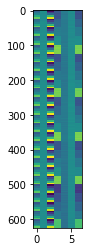

In [38]:
diff = targets - outputs
plt.imshow(diff, interpolation='none', aspect=0.05)
plt.show()

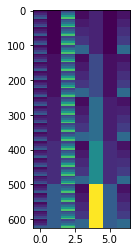

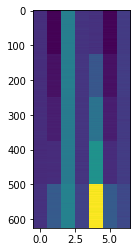

In [45]:
targets_outputs = np.concatenate((targets, outputs), axis=0)

plt.imshow(targets, interpolation='none', aspect=0.025)
plt.show()
plt.imshow(outputs, interpolation='none', aspect=0.025)
plt.show()

In [52]:
im = Image.fromarray(targets)
im.show()
if im.mode != 'RGB':
    im = im.convert('RGB')
im.save("targets.jpeg")

In [ ]:
targets